In [63]:
#Importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [64]:
df = pd.read_csv("/users/imbahndu/Desktop/Columbia DBM/New sound recording/pd_speech_features.csv")

In [65]:
df

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.265120,0.083127,...,0.071728,0.010352,-2.730300,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363615,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.220040,0.127410,...,0.729330,0.780410,5.229400,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.157560,0.116890,...,0.269510,-0.005522,0.350540,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.172950,0.147370,...,0.366920,-0.492650,0.191640,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.0295,2.0362,1.8478,2.5776,2.2064,1.9491,1.9120,1.8829,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4

In [66]:
#Finding nan values
series = df.isnull().sum().value_counts()
series

0    755
Name: count, dtype: int64

In [67]:
#Finding categorical values to one hot encode them 
string_list = []
for col in df.columns:
    if type(col) == "Object":
        string_list.append(col)

string_list


[]

In [68]:
#Renaming the gender column
df["gender"] = np.where(df["gender"] == 1, "Female", "Male")

In [69]:
#Verifying the label column to check balanced nature
df["class"].value_counts()


class
1    564
0    192
Name: count, dtype: int64

In [70]:
#Looking at numerical column
int_list = []
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        int_list.append(col)

int_list

['id',
 'PPE',
 'DFA',
 'RPDE',
 'numPulses',
 'numPeriodsPulses',
 'meanPeriodPulses',
 'stdDevPeriodPulses',
 'locPctJitter',
 'locAbsJitter',
 'rapJitter',
 'ppq5Jitter',
 'ddpJitter',
 'locShimmer',
 'locDbShimmer',
 'apq3Shimmer',
 'apq5Shimmer',
 'apq11Shimmer',
 'ddaShimmer',
 'meanAutoCorrHarmonicity',
 'meanNoiseToHarmHarmonicity',
 'meanHarmToNoiseHarmonicity',
 'minIntensity',
 'maxIntensity',
 'meanIntensity',
 'f1',
 'f2',
 'f3',
 'f4',
 'b1',
 'b2',
 'b3',
 'b4',
 'GQ_prc5_95',
 'GQ_std_cycle_open',
 'GQ_std_cycle_closed',
 'GNE_mean',
 'GNE_std',
 'GNE_SNR_TKEO',
 'GNE_SNR_SEO',
 'GNE_NSR_TKEO',
 'GNE_NSR_SEO',
 'VFER_mean',
 'VFER_std',
 'VFER_entropy',
 'VFER_SNR_TKEO',
 'VFER_SNR_SEO',
 'VFER_NSR_TKEO',
 'VFER_NSR_SEO',
 'IMF_SNR_SEO',
 'IMF_SNR_TKEO',
 'IMF_SNR_entropy',
 'IMF_NSR_SEO',
 'IMF_NSR_TKEO',
 'IMF_NSR_entropy',
 'mean_Log_energy',
 'mean_MFCC_0th_coef',
 'mean_MFCC_1st_coef',
 'mean_MFCC_2nd_coef',
 'mean_MFCC_3rd_coef',
 'mean_MFCC_4th_coef',
 'mean_MFCC

In [71]:
#Will implement a tree based model for balancing classes, then try logistic regression + svm, then try PCA if data is overfiiting 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [72]:
y = df["class"]
X = df.drop(columns=["class", "gender"], axis=1) 

print(y.shape)
print(X.shape)

(756,)
(756, 753)


In [73]:
#Preprocessing pipeline for logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

from sklearn.pipeline import make_pipeline

#Using make_pipeline to automate all the process of assigning variables and stuff
model_linear = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, C=10, class_weight="balanced"))

/users/imbahndu/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [74]:
model_linear.fit(X_train, y_train)


model_linear.predict_proba(X_test)

predictions = model_linear.predict(X_test)

acc_linear = accuracy_score(y_test, predictions)

acc_linear

0.832

In [75]:
#Using cross validation 
cvl = cross_val_score(model_linear, X_train, y_train, cv=5)
cvl

array([0.94155844, 0.86928105, 0.92156863, 0.96078431, 0.92156863])

In [76]:
#GridSearchCV for hyperparamters finetuning 

from sklearn.model_selection import GridSearchCV

c_list  = [0.1, 1, 10, 100, 1000]
max_iter_list = [100, 1000, 10000, 100000]
param_grid = {"logisticregression__C": c_list, "logisticregression__max_iter": max_iter_list}

grid = GridSearchCV(model_linear, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

dict_best_params = grid.best_params_

c_best = dict_best_params["logisticregression__C"]

max_iter_best = dict_best_params["logisticregression__max_iter"]

In [77]:
#Retraining the model for eval perfomance 
model_linear_eval = make_pipeline(StandardScaler(), LogisticRegression(max_iter=max_iter_best,C=c_best))

model_linear_eval.fit(X_train, y_train)

model_linear_eval.predict_proba(X_test)

new_predictions = model_linear_eval.predict(X_test)

acc_linear = accuracy_score(y_test, new_predictions)

acc_linear

#Potentially save the model upon approval by Prof.Orsun


0.812

<Axes: >

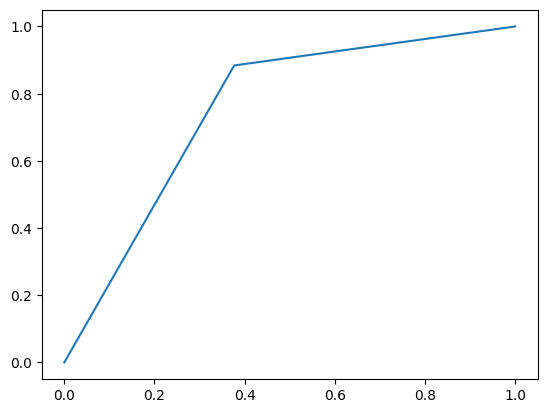

In [78]:
#Coputer auc-roc
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, new_predictions)
sns.lineplot(x=fpr_lr, y=tpr_lr)

In [79]:
#Evaluating the potential metrics

#Try SMOTE
class_report = classification_report(y_test, new_predictions)
print(class_report)


class_matrix = confusion_matrix(y_test, new_predictions)
print(class_matrix)

              precision    recall  f1-score   support

           0       0.67      0.62      0.65        69
           1       0.86      0.88      0.87       181

    accuracy                           0.81       250
   macro avg       0.77      0.75      0.76       250
weighted avg       0.81      0.81      0.81       250

[[ 43  26]
 [ 21 160]]


In [80]:
#Feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_regression, chi2, f_regression

selector = SelectKBest(score_func=f_regression, k=6)

X_train_new = selector.fit_transform(X_train, y_train)

X_test_new = selector.transform(X_test)

filter = selector.get_support(indices=True)

print(filter)

features_list = []

for i in filter:

    features_list.append(X_train.columns[i])

print(features_list)

[120 132 133 134 135 136]
['std_8th_delta', 'std_6th_delta_delta', 'std_7th_delta_delta', 'std_8th_delta_delta', 'std_9th_delta_delta', 'std_10th_delta_delta']


In [81]:
#Creating a new pd frame for features and find if there's some correlation with the target
new_pd = df[features_list]

new_pd["class"] = df["class"]

new_pd.corr()
 

/tmp/ipykernel_1398661/702519698.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_pd["class"] = df["class"]


,std_8th_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,class
std_8th_delta,1.000000,0.697324,0.742316,0.943712,0.762163,0.706631,0.342875
std_6th_delta_delta,0.697324,1.000000,0.767391,0.714505,0.736657,0.712132,0.349046
std_7th_delta_delta,0.742316,0.767391,1.000000,0.773222,0.752998,0.724621,0.354239
std_8th_delta_delta,0.943712,0.714505,0.773222,1.000000,0.806431,0.741930,0.364256
std_9th_delta_delta,0.762163,0.736657,0.752998,0.806431,1.000000,0.804631,0.364333
std_10th_delta_delta,0.706631,0.712132,0.724621,0.741930,0.804631,1.000000,0.335408
class,0.342875,0.349046,0.354239,0.364256,0.364333,0.335408,1.000000


PermutationExplainer explainer: 757it [25:07,  2.00s/it]                         
/tmp/ipykernel_1398661/378936380.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


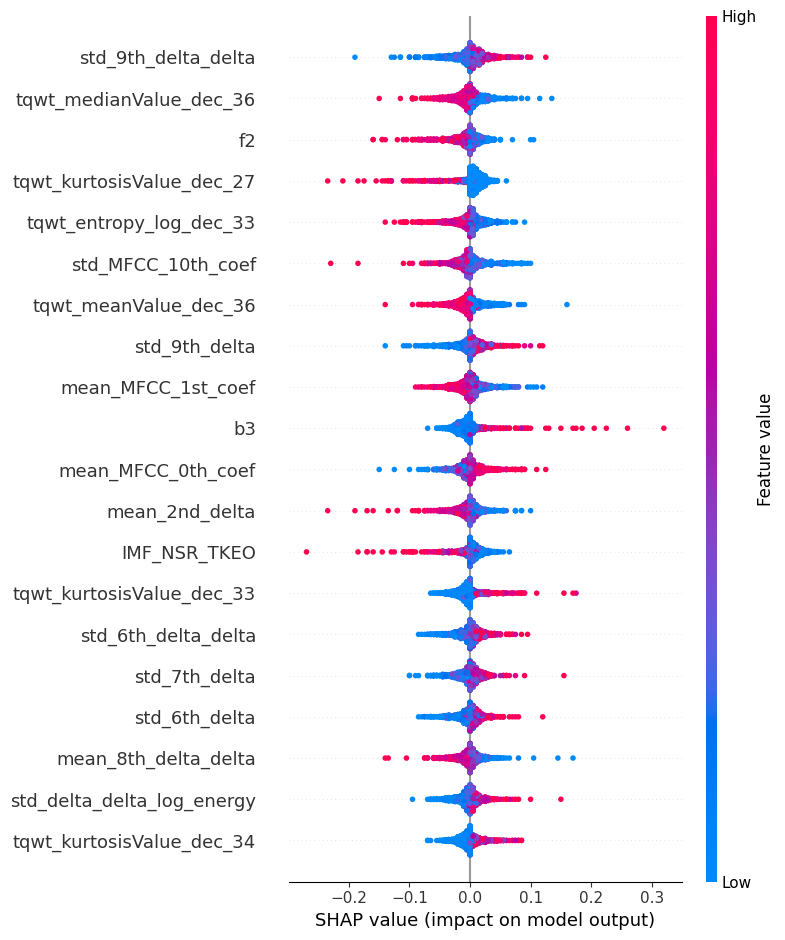

In [82]:
#Using SHAP for intepretability 
import shap

explainer = shap.Explainer(model_linear.predict, X, max_evals=1500)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

Moving on with Random Forest Classifier Model

In [83]:
#a)RFC Model
model_tree = RandomForestClassifier(n_estimators=50, min_samples_leaf=2, min_samples_split=3, class_weight="balanced")

model_tree.fit(X_train, y_train)

class_label_predictions = model_tree.predict_proba(X_test)[:1]

label_predictions = model_tree.predict(X_test)

acc_forest = accuracy_score(y_test, label_predictions)

acc_forest

0.82

In [84]:
cm_rf = confusion_matrix(y_test, label_predictions)

cm_rf

array([[ 42,  27],
       [ 18, 163]])

In [93]:
#Cross val on random forest 
cvl_tree = cross_val_score(model_tree, X_train, y_train, cv=5)
print(cvl)
print(np.mean(cvl))

[0.94155844 0.86928105 0.92156863 0.96078431 0.92156863]
0.9229522111875053


In [86]:
n_estimators = np.arange(50, 110, 10).tolist()
min_samples_leaf = np.arange(2, 10, 2).tolist()
min_samples_split = np.arange(2,10,2).tolist()

print(n_estimators)
print(min_samples_leaf)
print(min_samples_split)

[50, 60, 70, 80, 90, 100]
[2, 4, 6, 8]
[2, 4, 6, 8]


In [87]:
param_grid_rf = {"n_estimators": n_estimators, "min_samples_leaf": min_samples_leaf, "min_samples_split": min_samples_split }

grid_rf = GridSearchCV(model_tree, param_grid=param_grid_rf, cv=5, error_score='raise')

grid_rf.fit(X_train, y_train)

rf_best_params = grid_rf.best_params_

rf_best_params

min_lf = rf_best_params["min_samples_leaf"]

min_sp = rf_best_params["min_samples_split"]

n_est = rf_best_params["n_estimators"]

In [88]:
#Retrain random forest with hyperparameters

model_tree = RandomForestClassifier(n_estimators=n_est, min_samples_leaf=min_lf, min_samples_split=min_sp, class_weight="balanced")

model_tree.fit(X_train, y_train)

class_label_predictions = model_tree.predict_proba(X_test)[:1]

label_predictions = model_tree.predict(X_test)

acc_forest = accuracy_score(y_test, label_predictions)

acc_forest

0.856

In [89]:
new_cm = confusion_matrix(y_test, label_predictions)

new_cm

array([[ 45,  24],
       [ 12, 169]])

<Axes: >

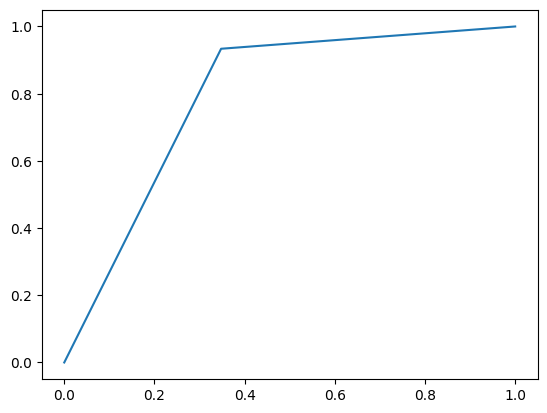

In [90]:
#Computer AUC-ROC scores
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_test, label_predictions)
sns.lineplot(x=fpr, y=tpr)

In [ ]:
#Finding feature importance using random tree

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)


importance_df


,Feature,Importance
111,std_delta_log_energy,0.024369
133,std_7th_delta_delta,0.018859
132,std_6th_delta_delta,0.016728
134,std_8th_delta_delta,0.015184
476,tqwt_TKEO_std_dec_12,0.013637
...,...,...
601,tqwt_stdValue_dec_29,0.000000
608,tqwt_stdValue_dec_36,0.000000
169,det_entropy_log_10_coef,0.000000
223,app_TKEO_std_4_coef,0.000000


In [ ]:
#Store both in pkl files and / or  Github push them